In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, SobolIndices, KrigingModel, RandomForestModel
from shapley.tests import Ishigami
from shapley.tests.utils import true_gaussian_full_ind_sobol
from shapley.plots import set_style_paper, plot_sensitivity_results
from shapley.plots import plot_correlation_indices

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [0., 1.]

In [2]:
model = Ishigami()
dim = model.dim
model.copula = ot.NormalCopula(dim)

In [3]:
n_corr = 20
corrs = np.linspace(-0.999, 0.999, n_corr)

n_var = 5000
n_outer = 100
n_inner = 50
n_perms = None
c_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * c_perms * (dim - 1)
n_sample = int(max_budget / (dim*4))
n_sample = 5400
print('Max budget:', max_budget)

estimator_sobol_full_ind = 'sobolmara'
n_boot = 300

Max budget: 65000


In [4]:
use_meta_model = False
n_realization = 1
if use_meta_model:
    ot.RandomGenerator.SetSeed(0)
    np.random.seed(0)
    model_budget = 20
    n_realization = 300
    basis = 'quadratic'
    kernel = 'matern'
    library = 'sklearn'
    sampling = 'lhs'
    model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
    model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
    model_gp.build(library=library, kernel=kernel, basis_type=basis)
    
    n_sample_cv = 10000
    score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='monte-carlo')
    print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

In [5]:
result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

true_result_indices = {'Shapley': [],
                  'First Sobol': [],
                  'Total Sobol': [],
                  'First full Sobol': [],
                  'Total full Sobol': [],
                  'First ind Sobol': [],
                  'Total ind Sobol': []
                 }

for corr in corrs:
    print('Corr:', corr)
    theta = [0., 0., corr]
    model.copula_parameters = theta
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
        
    #Sobol Full and Ind
    if use_meta_model:
        sobol = SobolKrigingIndices(model.input_distribution)
        sobol.build_uncorr_sample(meta_model, n_sample, n_realization=n_realization)
    else:
        sobol = SobolIndices(model.input_distribution)
        sobol.build_uncorr_sample(model, n_sample)
        
    sobol_results_full = sobol.compute_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind, indice_type='full')
    sobol_results_ind = sobol.compute_indices(n_boot=n_boot, estimator=estimator_sobol_full_ind, indice_type='ind')
    
    # Shapley
    if use_meta_model:
        shapley = ShapleyKrigingIndices(model.input_distribution)
        shapley.build_sample(model=model_gp, n_perms=None, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)
    else:
        shapley = ShapleyIndices(model.input_distribution)
        shapley.build_sample(model=model, n_perms=None, n_var=n_var, n_outer=n_outer, n_inner=n_inner)
    
    shapley_results = shapley.compute_indices(n_boot=n_boot)
    
    # Save results
    result_indices['Shapley'].append(shapley_results.full_shapley_indices.ravel())
    result_indices['First Sobol'].append(shapley_results.full_first_indices.ravel())
    result_indices['Total Sobol'].append(shapley_results.full_total_indices.ravel())
    result_indices['First full Sobol'].append(sobol_results_full.full_first_indices.ravel())
    result_indices['Total full Sobol'].append(sobol_results_full.full_total_indices.ravel())    
    result_indices['First ind Sobol'].append(sobol_results_ind.full_first_indices.ravel())
    result_indices['Total ind Sobol'].append(sobol_results_ind.full_total_indices.ravel())

('Corr:', -0.999)
('Corr:', -0.89384210526315788)
('Corr:', -0.78868421052631577)
('Corr:', -0.68352631578947376)
('Corr:', -0.57836842105263164)
('Corr:', -0.47321052631578953)
('Corr:', -0.36805263157894741)
('Corr:', -0.26289473684210529)
('Corr:', -0.15773684210526318)
('Corr:', -0.052578947368421058)
('Corr:', 0.052578947368420947)
('Corr:', 0.15773684210526306)
('Corr:', 0.26289473684210518)
('Corr:', 0.3680526315789473)
('Corr:', 0.47321052631578941)
('Corr:', 0.57836842105263153)
('Corr:', 0.68352631578947365)
('Corr:', 0.78868421052631577)
('Corr:', 0.89384210526315788)
('Corr:', 0.999)


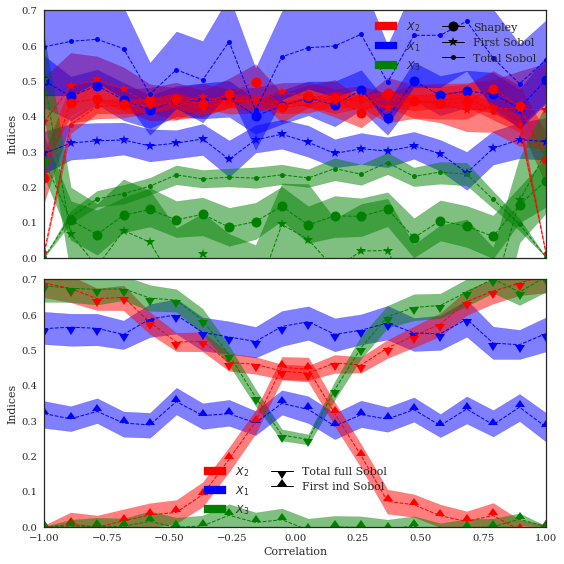

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)

ax = axes[0]
to_plot = ['Shapley', 'First Sobol', 'Total Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_xlabel('')
ax.set_ylim(0., 0.7)

ax = axes[1]
to_plot = ['First ind Sobol', 'Total full Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')

ax.set_ylim(0., 0.7)
fig.tight_layout()
fig.savefig('./output/correlation_ishigami_both_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, n_var, n_outer, n_inner))

In [10]:
from skgarden import RandomForestQuantileRegressor
from shapley.forest import compute_perm_indices, compute_shap_indices, compute_1stperm_indices
n_tree = 50
rf_first_indices = np.zeros((n_corr, dim, n_tree))
rf_total_indices = np.zeros((n_corr, dim, n_tree))
rf_shapley_indices = np.zeros((n_corr, dim, n_tree))
for i, corr in enumerate(corrs):
    theta = [0., 0., corr]
    model.copula_parameters = theta
    model_rf = RandomForestModel(model, input_distribution=model.input_distribution)
    model_rf.generate_sample(n_sample=2000, sampling='monte-carlo', sampling_type='classic')
    X = model_rf.input_sample
    y = model_rf.output_sample
    forest = RandomForestQuantileRegressor(n_estimators=n_tree, n_jobs=7)
    forest.fit(X, y)
    rf_first_indices[i] = compute_1stperm_indices(forest, X, y, model.input_distribution)
    rf_total_indices[i] = compute_perm_indices(forest, X, y, model.input_distribution)
    rf_shapley_indices[i] = compute_shap_indices(forest, X, y, model.input_distribution)

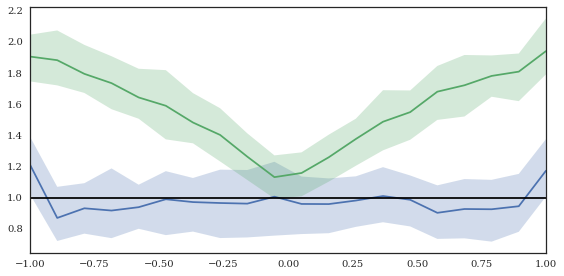

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
for indices in [rf_first_indices, rf_total_indices]:
    ind = indices.sum(axis=1)
    ax.plot(corrs, ind.mean(axis=1))
    quantiles = np.percentile(ind, [1, 99], axis=1)
    ax.fill_between(corrs, quantiles[0, :], quantiles[1, :], alpha=0.25)
ax.plot([corrs[0], corrs[-1]], [1]*2, 'k')
ax.set_xlim(corrs[0], corrs[-1])
fig.tight_layout()

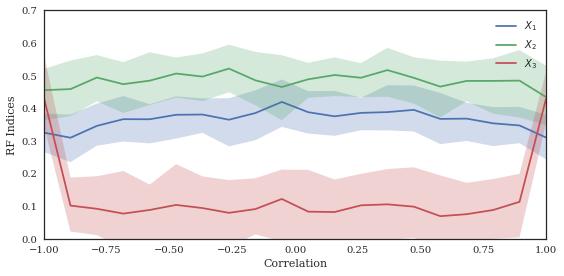

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(dim):
    rf_indice = rf_first_indices[:, i]
    ax.plot(corrs, rf_indice.mean(axis=1), label="$X_%d$" % (i+1))
    quantiles = np.percentile(rf_indice, [2.5, 97.5], axis=1)
    ax.fill_between(corrs, quantiles[0, :], quantiles[1, :], alpha=0.25)
    
to_plot = ['Total full Sobol']
#plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.legend(loc=0)
ax.set_ylim(0., 0.7)
ax.set_xlim(corrs[0], corrs[-1])
ax.set_xlabel('Correlation')
ax.set_ylabel('RF Indices')
fig.tight_layout()

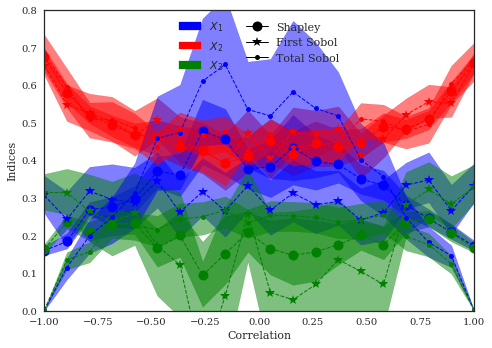

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))

to_plot = ['Shapley', 'First Sobol', 'Total Sobol']

plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_ylim([0., 0.8])
fig.tight_layout()
fig.savefig('./output/correlation_ishigami_dim_%d_Nv_%d_No_%d_Ni_%d.pdf' % (dim, Nv, No, Ni))

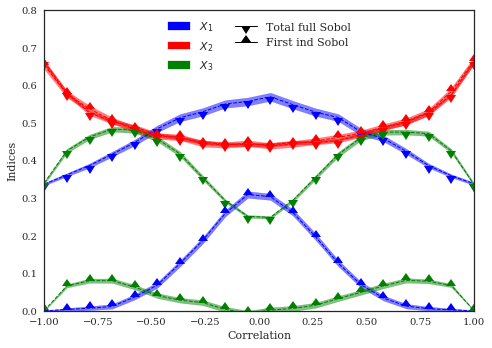

In [76]:
fig, ax = plt.subplots(figsize=(7, 5))

to_plot = ['First ind Sobol', 'Total full Sobol']
plot_correlation_indices(result_indices, corrs, n_boot, ax=ax, to_plot=to_plot, alpha=[0.025, 0.975], ci='error')
ax.set_ylim([0., 0.8])
fig.tight_layout()